In [1]:
import os
import librosa   #thư viện xủ lý tín hiệu âm thanh
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #để đọc file wav 
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

c:\python 3.7\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\python 3.7\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\python 3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [2]:
train_audio_path = 'D:/DATA/voice/train/audio/'
labels=os.listdir(train_audio_path)

all_wave = []
all_label = []
all_chroma = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
#         samples = librosa.resample(samples, sample_rate, 16000)
        
        leng = len(samples)
        
        samples = samples[leng-23000:leng-1000]# number of samples =22000 equals 1.375 seconds
        chroma = librosa.feature.chroma_stft(y=samples, sr=16000)
#         print((chroma.shape))
#         if len(samples) ==22000:
        all_wave.append(samples)
        all_chroma.append(chroma)
        all_label.append(label)

0
1
2
3
4
5
6
7
8
9
noise


In [3]:
all_chroma = np.array(all_chroma)
print(all_chroma.shape)
samples

(100, 12, 43)


array([ 0.311615  ,  0.3819275 ,  0.93463135, ...,  0.06591797,
       -0.22793579,  0.12792969], dtype=float32)

6


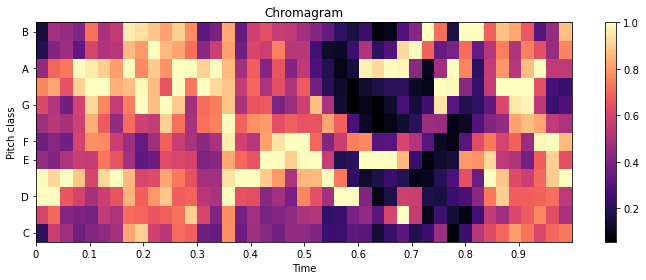

In [4]:
import matplotlib.pyplot as plt
import librosa.display

testID = 61
print(all_label[testID])
chroma = all_chroma[testID]

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()


In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
all_chroma = np.array(all_chroma).reshape(-1,12,43,1)
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_chroma),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

Using TensorFlow backend.


In [6]:
all_chroma[1].shape

(12, 43, 1)

In [7]:
print(tf.__version__)

1.13.1


In [8]:
x_tr.shape

(80, 12, 43, 1)

In [9]:
#thiết kế mô hình deep learning
from keras.models import Model, Sequential
from keras.layers import *
from keras.activations import *
from keras.optimizers import Adam,RMSprop,SGD
model1 = Sequential()

model1.add(Conv2D(8, kernel_size=(12, 12), strides= (2, 2), padding='same',data_format='channels_last',input_shape=( 12, 43,1)))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(16, kernel_size=(6, 6), strides= (1, 1), padding='same'))
model1.add(LeakyReLU(alpha=0.1))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dropout(0.1))
model1.add(Dense(11))
model1.add(Activation('sigmoid'))
optimizer = Adam(lr=0.001)
opt = SGD(lr=0.01, momentum=0.9)
model1.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 22, 8)          1160      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6, 22, 8)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 11, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 11, 16)         4624      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 3, 11, 16)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 5, 16)          0         
________________________________________________

In [10]:
#luyện mô hình 
classifier = model1.fit(x_tr,
                    y_tr,
                    epochs=100,
                    batch_size=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
80/80 [==============================] - 1s 14ms/step - loss: 2.4085 - accuracy: 0.0875
Epoch 2/100
80/80 [==============================] - 0s 362us/step - loss: 2.3989 - accuracy: 0.0875
Epoch 3/100
80/80 [==============================] - 0s 374us/step - loss: 2.3870 - accuracy: 0.1625
Epoch 4/100
80/80 [==============================] - 0s 361us/step - loss: 2.3831 - accuracy: 0.1250
Epoch 5/100
80/80 [==============================] - 0s 337us/step - loss: 2.3752 - accuracy: 0.1250
Epoch 6/100
80/80 [==============================] - 0s 312us/step - loss: 2.3685 - accuracy: 0.1125
Epoch 7/100
80/80 [==============================] - 0s 337us/step - loss: 2.3553 - accuracy: 0.2250
Epoch 8/100
80/80 [==============================] - 0s 299us/step - loss: 2.3552 - accuracy: 0.1250
Epoch 9/100
80/80 [==============================] - 0s 299us/step - loss: 2.3441 - accuracy: 0.1500
Epoch 10/100
80/80 [========================

80/80 [==============================] - 0s 324us/step - loss: 0.0264 - accuracy: 1.0000
Epoch 80/100
80/80 [==============================] - 0s 299us/step - loss: 0.0111 - accuracy: 1.0000
Epoch 81/100
80/80 [==============================] - 0s 287us/step - loss: 0.0127 - accuracy: 1.0000
Epoch 82/100
80/80 [==============================] - 0s 299us/step - loss: 0.0150 - accuracy: 1.0000
Epoch 83/100
80/80 [==============================] - 0s 287us/step - loss: 0.0120 - accuracy: 1.0000
Epoch 84/100
80/80 [==============================] - 0s 312us/step - loss: 0.0091 - accuracy: 1.0000
Epoch 85/100
80/80 [==============================] - 0s 287us/step - loss: 0.0125 - accuracy: 1.0000
Epoch 86/100
80/80 [==============================] - 0s 299us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 87/100
80/80 [==============================] - 0s 287us/step - loss: 0.0113 - accuracy: 1.0000
Epoch 88/100
80/80 [==============================] - 0s 312us/step - loss: 0.0119 - accuracy: 

In [11]:
#kiểm tra mô hình sau khi luyện
model1.predict(all_chroma)[40]

array([1.0728836e-06, 0.0000000e+00, 6.8545341e-07, 8.1956387e-06,
       3.3138686e-01, 6.0141087e-05, 2.8312206e-06, 6.9439411e-06,
       3.6954880e-06, 0.0000000e+00, 2.8952956e-04], dtype=float32)

In [12]:
all_label[40]

'4'

In [13]:
# lưu kiến trúc của model đã luyện vào file json
model_json = model1.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# lưu các trọng số của model
model1.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
